In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from glob import glob
import random
import trimesh

7
/common/users/dm1487/inhand_manipulation_data_store/datastore_41_01-22-24/23-54-31/4/2024-01-23_00-53-25.npz
998


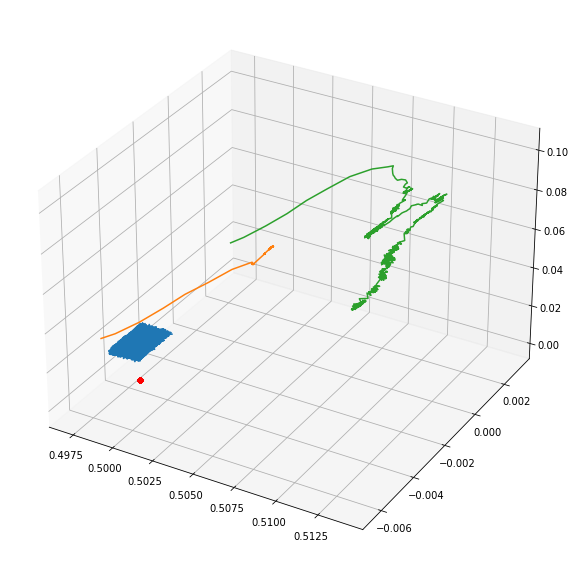

In [4]:
all_paths = glob('/common/users/dm1487/inhand_manipulation_data_store/datastore_41_01-22-24/23-54-31/*/*.npz')

plug_mesh = trimesh.load("/common/users/dm1487/isaacgym_new/python/IsaacGymInsertion/assets/factory/mesh/factory_insertion/yellow_round_peg_2in.obj")
socker_mesh = trimesh.load("/common/users/dm1487/isaacgym_new/python/IsaacGymInsertion/assets/factory/mesh/factory_insertion/green_round_hole_2in.obj")

print(len(all_paths))
path = random.sample(all_paths, 1)[0]
data = np.load(path)
# path = random.sample(all_paths, 1)[0]
print(path)
done_idx = data['done'].nonzero()[-1][0]

print(done_idx)
ax = plt.figure(figsize=(10, 20)).add_subplot(projection='3d')

ax.scatter(data['socket_pos'][:done_idx, 0], data['socket_pos'][:done_idx, 1], zs=data['socket_pos'][:done_idx, 2], color='r')
ax.plot(data['noisy_socket_pos'][:done_idx, 0], data['noisy_socket_pos'][:done_idx, 1], zs=data['noisy_socket_pos'][:done_idx, 2])
ax.plot(data['plug_pos'][:done_idx, 0], data['plug_pos'][:done_idx, 1], zs=data['plug_pos'][:done_idx, 2])
ax.plot(data['eef_pos'][:done_idx, 0], data['eef_pos'][:done_idx, 1], zs=data['eef_pos'][:done_idx, 2])

In [5]:
data['eef_pos'].shape

(1000, 12)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
7
/common/users/dm1487/inhand_manipulation_data_store/datastore_41_01-22-24/23-54-31/23/2024-01-23_00-52-10.npz
1
(1000, 500)


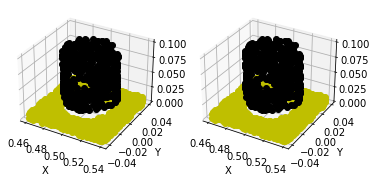

In [5]:
import open3d as o3d
print(len(all_paths))
path = random.sample(all_paths, 1)[0]
data = np.load(path)
# path = random.sample(all_paths, 1)[0]
print(path)
done_idx = data['done'].nonzero()[-1][0]
plug_mesh = trimesh.load("/common/users/dm1487/isaacgym_new/python/IsaacGymInsertion/assets/factory/mesh/factory_insertion/yellow_round_peg_2in.obj")
socket_mesh = trimesh.load("/common/users/dm1487/isaacgym_new/python/IsaacGymInsertion/assets/factory/mesh/factory_insertion/green_round_hole_2in.obj")

# Define positions
# plug_pos = np.array([x, y, z, quat_w, quat_x, quat_y, quat_z])  # Replace with actual values
# socket_pos = np.array([x, y, z, quat_w, quat_x, quat_y, quat_z])  # Replace with actual values
idx = np.random.randint(0, 50)
print(idx)
plug_pos = data['plug_pos'][idx]
socket_pos = data['socket_pos'][0]
import torch
dec_ = torch.sigmoid(torch.from_numpy(data['dec'])).numpy()
print(dec_.shape)
dec = dec_[idx]
# print(dec[50])
T = np.eye(4)
T[0:3, -1] = socket_pos[:3]
socket_mesh.apply_transform(T)

scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(
    o3d.t.geometry.TriangleMesh.from_legacy(socket_mesh.as_open3d)
)
socket_pcl = trimesh.sample.sample_surface_even(socket_mesh, 1000, seed=42)[0]

T = np.zeros((4, 4))

T[0:3, 0:3] = plug_pos[3:].reshape(3, 3)
T[0:3, -1] = plug_pos[:3]
T[3, 3] = 1

plug_mesh = plug_mesh.apply_transform(T)
pointcloud_obj = trimesh.sample.sample_surface(plug_mesh, 500, seed=42)[0]
object_pc = trimesh.points.PointCloud(pointcloud_obj.copy())
query_points = object_pc.copy().vertices
d = scene.compute_distance(o3d.core.Tensor.from_numpy(query_points.astype(np.float32))).numpy()
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')

# ax.view_init(elev=0, azim=45, roll=0)
ax.plot(socket_pcl[:, 0], socket_pcl[:, 1], socket_pcl[:, 2], 'yo')
ax.plot(query_points[:, 0], query_points[:, 1], query_points[:, 2], 'ko')
ax.set_xlabel('X')
ax.set_ylabel('Y')


intersecting_indices = d < 0.002
contacts = np.zeros_like(query_points)
contacts[intersecting_indices] = query_points[intersecting_indices]
for c in contacts:
    if np.linalg.norm(c, axis=0):
        ax.plot(c[0], c[1], c[2], 'ro')

ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.plot(socket_pcl[:, 0], socket_pcl[:, 1], socket_pcl[:, 2], 'yo')
ax1.plot(query_points[:, 0], query_points[:, 1], query_points[:, 2], 'ko')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')


intersecting_indices = dec > 0.8
contacts = np.zeros_like(query_points)
contacts[intersecting_indices] = query_points[intersecting_indices]
for c in contacts:
    if np.linalg.norm(c, axis=0):
        ax1.plot(c[0], c[1], c[2], 'ro')

# print(plug_pos.shape, socket_pos.shape)

# # Extract x, y, z from the sequence
# plug_xyz = plug_pos[:3]
# socket_xyz = socket_pos[:3]

# # Extract the flattened rotation matrix from the sequence and reshape it
# plug_rot_matrix = plug_pos[3:].reshape((3, 3))
# socket_rot_matrix = socket_pos[3:].reshape((3, 3))

# # Create Open3D visualizer
# vis = o3d.visualization.Visualizer()
# vis.create_window()

# # Create Open3D point cloud objects
# plug_point_cloud = o3d.geometry.PointCloud()
# plug_point_cloud.points = o3d.utility.Vector3dVector(plug_mesh.vertices.dot(plug_rot_matrix.T) + plug_xyz)

# socket_point_cloud = o3d.geometry.PointCloud()
# socket_point_cloud.points = o3d.utility.Vector3dVector(socket_mesh.vertices.dot(socket_rot_matrix.T) + socket_xyz)

# # Create Open3D visualizer
# vis = o3d.visualization.Visualizer()
# vis.create_window()

# # Add point clouds to the visualizer
# vis.add_geometry(plug_point_cloud)
# vis.add_geometry(socket_point_cloud)

# Set camera parameters (eye, at, up)
# camera_params = {
#     "eye": np.array([0, 0, 5]),   # Set the camera position
#     "at": np.array([0, 0, 0]),    # Set the look-at position
#     "up": np.array([0, 1, 0])     # Set the up vector
# }

# # Set the camera parameters using reset_view_point
# vis.get_view_control().set_lookat(camera_params["at"])
# vis.get_view_control().set_front(camera_params["up"])
# vis.get_view_control().set_eye(camera_params["eye"])

# # Run the visualizer
# vis.run()

# {
# 	"class_name" : "ViewTrajectory",
# 	"interval" : 29,
# 	"is_loop" : false,
# 	"trajectory" : 
# 	[
# 		{
# 			"boundingbox_max" : [ 0.54039999999999999, 0.040399999999999998, 0.098255072227159526 ],
# 			"boundingbox_m 91%|████████████████████████████████████████████████████████████▏     | 1in" : [ 0.46039999999999998, -0.039600000000000003, 0.0010000001639127731 ],
# 			"field_of_view" : 60.0,
# 			"front" : [ 0.2834188788849098, 0.95643546243668398, 0.07003531455735286 ],
# 			"lookat" : [ 0.48460054925067825, 0.0039802520111926693, 0.04365890114519666 ],
# 			"up" : [ 0.21977027487956474, -0.13586309814078501, 0.96604463915646677 ],
# 			"zoom" : 0.84000000000000008
# 		}
# 	],
# 	"version_major" : 1,
# 	"version_minor" : 0
# }

# img = np.asarray(vis.capture_screen_float_buffer())

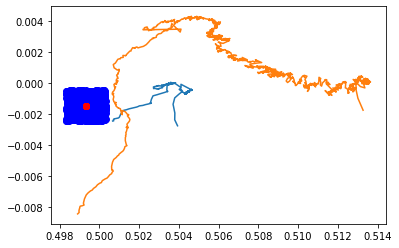

In [6]:
plt.scatter(data['noisy_socket_pos'][1:done_idx, 0], data['noisy_socket_pos'][1:done_idx, 1], color='b')
plt.plot(data['plug_pos'][1:done_idx, 0], data['plug_pos'][1:done_idx, 1])
plt.plot(data['eef_pos'][1:done_idx, 0], data['eef_pos'][1:done_idx, 1])
plt.scatter(data['socket_pos'][1:done_idx, 0], data['socket_pos'][1:done_idx, 1], color='r', s=35)

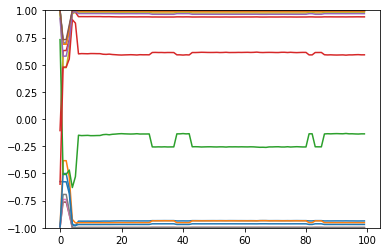

In [7]:
path = random.sample(all_paths, 1)[0]
data = np.load(path)
latent = data['latent']
plt.ylim(-1, 1)
plt.plot(latent[:100, :])

In [8]:
# forces = data['forces_latent']
# fig, ax = plt.subplots(1, 3, figsize=(24, 4))
# ax[0].plot(forces[:done_idx, 0], label='left')
# ax[1].plot(forces[:done_idx, 1], label='right')
# ax[2].plot(forces[:done_idx, 2], label='center')

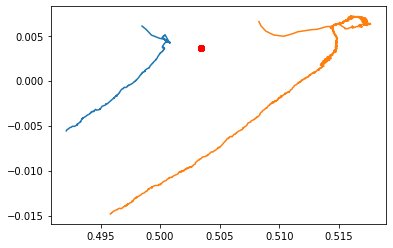

In [9]:
# plt.scatter(data['noisy_socket_pos'][1:done_idx, 0], data['noisy_socket_pos'][1:done_idx, 1], color='b')
plt.plot(data['plug_pos'][1:done_idx, 0], data['plug_pos'][1:done_idx, 1])
plt.plot(data['eef_pos'][1:done_idx, 0], data['eef_pos'][1:done_idx, 1])
plt.scatter(data['socket_pos'][1:done_idx, 0], data['socket_pos'][1:done_idx, 1], color='r', s=35)

(1000, 3, 112, 224, 1)

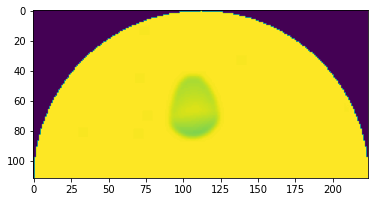

In [10]:
plt.imshow((((data['tactile'][50][1][:]+1)/2)*255).astype(np.int8))

data['tactile'].shape

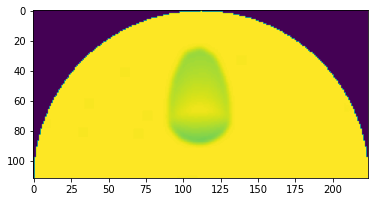

In [11]:
plt.imshow(((data['tactile'][3, 1, ...] + 1) * 255).astype(np.uint8))

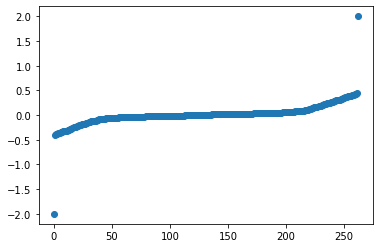

In [12]:
t = (data['tactile'] + 0.5) * 2
k = 2
m = np.unique((t[k:, ...] - t[:-k, ...] ).flatten())
plt.scatter(range(len(m)), m)

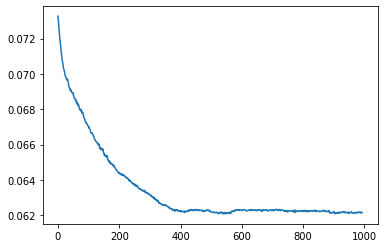

In [13]:
plt.plot(data['plug_hand_pos'][4:done_idx, 2])

In [16]:
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from pytransform3d import rotations as pr
from pytransform3d import transformations as pt
from pytransform3d.transform_manager import TransformManager

def get_pcd_plot(plug_pos, socket_pos, dec):
    # socket_pos = data['socket_pos'][0]
    socket_mesh = trimesh.load("/common/users/dm1487/isaacgym_new/python/IsaacGymInsertion/assets/factory/mesh/factory_insertion/green_round_hole_2in.obj")
    T = np.eye(4)
    T[0:3, -1] = socket_pos[:3]
    socket_mesh.apply_transform(T)
    
    scene = o3d.t.geometry.RaycastingScene()
    scene.add_triangles(
        o3d.t.geometry.TriangleMesh.from_legacy(socket_mesh.as_open3d)
    )
    socket_pcl = trimesh.sample.sample_surface_even(socket_mesh, 1000, seed=42)[0]
    T = np.zeros((4, 4))
    T[0:3, 0:3] = plug_pos[3:].reshape(3, 3)
    T[0:3, -1] = plug_pos[:3]
    T[3, 3] = 1
    plug_mesh = trimesh.load("/common/users/dm1487/isaacgym_new/python/IsaacGymInsertion/assets/factory/mesh/factory_insertion/yellow_round_peg_2in.obj")
    plug_mesh = plug_mesh.apply_transform(T)
    pointcloud_obj = trimesh.sample.sample_surface(plug_mesh, 500, seed=42)[0]
    object_pc = trimesh.points.PointCloud(pointcloud_obj.copy())
    query_points = object_pc.copy().vertices
    d = scene.compute_distance(o3d.core.Tensor.from_numpy(query_points.astype(np.float32))).numpy()
    my_dpi = 72
    w = (224*3)/my_dpi
    h = (224*2)/my_dpi
    fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='3d'))
    fig.set_size_inches(w, h, forward=True)
    # ax[0] = fig.add_subplot(projection='3d')
    ax.plot(socket_pcl[:, 0], socket_pcl[:, 1], socket_pcl[:, 2], 'yo')
    ax.plot(query_points[:, 0], query_points[:, 1], query_points[:, 2], 'ko')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    # intersecting_indices = d < 0.002
    intersecting_indices = dec > 0.5
    contacts = np.zeros_like(query_points)
    contacts[intersecting_indices] = query_points[intersecting_indices]
    for c in contacts:
        if np.linalg.norm(c, axis=0):
            ax.plot(c[0], c[1], c[2], 'ro')
    plt.savefig('./temp_pcd.png')
    plt.close()
    return './temp_pcd.png'

def get_rel_pose(rel_plug_pos, eef_pos):
    tm = TransformManager()

    fig = plt.figure()
    my_dpi = 72
    w = (224*3)/my_dpi
    h = (224*1)/my_dpi
    fig.set_size_inches(w, h, forward=True)
    rel_plug_pos[2] /= 20
    object2cam = pt.transform_from_pq(np.hstack((rel_plug_pos[0:3],
                                                     pr.quaternion_wxyz_from_xyzw(
                                                         rel_plug_pos[3:]))))

    # print(rel_plug_pos)
    tm.add_transform("object", "world", object2cam)
    eef_quat = R.from_matrix(eef_pos[3:].reshape(3, 3)).as_quat()
    eef2cam = pt.transform_from_pq(np.hstack((eef_pos[:3]*0.0,
                                                     pr.quaternion_wxyz_from_xyzw(
                                                         eef_quat))))
    
    tm.add_transform("eef", "world", eef2cam)
    
    ax = tm.plot_frames_in("world", s=0.001, show_name=False)
    ax.set_xlim((-0.002, 0.002))
    ax.set_ylim((-0.002, 0.002))
    ax.set_zlim((-0.0, 0.01))
    plt.savefig('./temp_pcd1.png')
    plt.close()
    return './temp_pcd1.png'
    

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm

my_dpi = 72
w = (224*3)/my_dpi
h = 224./my_dpi

for video_id in range(300, 315):
    all_paths = sorted(glob('/common/users/dm1487/inhand_manipulation_data_store/datastore_41_01-22-24/23-54-31/*/*.npz'))
    # print(all_paths)
    path = random.sample(all_paths, 1)[0]
    data = np.load(path)
    done_idx = data['done'].nonzero()[-1][0]

    fourcc = cv2.VideoWriter_fourcc(*'XVID') 
    video = cv2.VideoWriter(f'video_{video_id}.avi', fourcc, 3, (int(224*6), int(224*3)), isColor=True)
    
    last_tactile = np.zeros_like(data['tactile'][0])
    tactile_img = data['tactile']
    dec_ = torch.sigmoid(torch.from_numpy(data['dec'])).numpy().copy()
    plug_pos = data['plug_pos']
    socket_pos = data['socket_pos']
    eef_pos = data['eef_pos']
    plug_hand_pos = np.concatenate([data['plug_hand_pos'], data['plug_hand_quat']], axis=-1)
    for j in tqdm(range(0, min(150, done_idx))):
        fn = get_pcd_plot(plug_pos[j], socket_pos[j], dec_[j])
        pcd = cv2.imread(fn)

        fn = get_rel_pose(plug_hand_pos[j], eef_pos[j])
        rel_pose = cv2.imread(fn)

        
        left_img = np.concatenate([pcd, rel_pose], axis=0)
        
        
        fig, ax = plt.subplots(1, 3)
        fig.set_size_inches(w, h, forward=True)
        
        ax[0].plot(plug_hand_pos[max(0, j-30):j, 0], label='x')
        
        ax[1].plot(plug_hand_pos[max(0, j-30):j, 1], label='y')
        
        ax[2].plot(plug_hand_pos[max(0, j-30):j, 2], label='z')
        
        
        fig.tight_layout()
        plt.savefig("./temp.png")
        plts = cv2.imread("./temp.png")
    
        # break
        
        img1 = (tactile_img[j][0]).copy()
        img2 = (tactile_img[j][1]).copy()
        img3 = (tactile_img[j][2]).copy()

        t_img = np.zeros((224, 224, 3))
        t_img[:112, :224, :] = img1
        img1 = t_img.copy()

        t_img = np.zeros((224, 224, 3))
        t_img[:112, :224, :] = img2
        img2 = t_img.copy()
        
        t_img = np.zeros((224, 224, 3))
        t_img[:112, :224, :] = img3
        img3 = t_img.copy()
        
        img_d1 = (tactile_img[j][0] - last_tactile[0]).copy()
        img_d2 = (tactile_img[j][1] - last_tactile[1]).copy() 
        img_d3 = (tactile_img[j][2] - last_tactile[2]).copy()

        t_img = np.zeros((224, 224, 3))
        t_img[:112, :224, :] = img_d1
        img_d1 = t_img.copy()

        t_img = np.zeros((224, 224, 3))
        t_img[:112, :224, :] = img_d2
        img_d2 = t_img.copy()
        
        t_img = np.zeros((224, 224, 3))
        t_img[:112, :224, :] = img_d3
        img_d3 = t_img.copy()
        
        last_tactile = tactile_img[j].copy()
        
        img = np.concatenate([img1, img2, img3], axis=1)
        img_d = np.concatenate([img_d1, img_d2, img_d3], axis=1) 
        
        # img = np.concatenate([img, img, img], axis=-1)
        # img_d = np.concatenate([img_d, img_d, img_d], axis=-1)
        img = np.concatenate([(((img+1)/2)*255), ((((img_d+1)/2)*255)), plts], axis=0)
        
        img = np.concatenate([left_img, img], axis=1)
        
        video.write(img.astype(np.uint8))
        plt.close()
        
    cv2.destroyAllWindows()
    video.release()

100%|█████████████████████████████████████████| 150/150 [01:23<00:00,  1.80it/s]


In [ ]:
data['latent'].max()

In [33]:
from tqdm import tqdm
import os
maxs, mins, means = [], [], []
means1, means2, means3 = [], [], []
for i in tqdm(random.sample(all_paths, 2000)):
    dat = np.load(i)
    done_idx = dat['done'].nonzero()[-1][0]
    if done_idx == 0:
        print(i)
        os.remove(i)
        continue
    # arm_joints = dat["arm_joints"]
    # eef_pos = dat["eef_pos"]
    # noisy_socket_pos = dat["noisy_socket_pos"][..., :3]
    arg = dat["target"]
    # target = dat["target"]
    # latent = dat["latent"]
    
    
    # action = (dat['action'] - np.array([ 0.2201746 ,  0.14593899, -0.31790477, -0.08718379, -0.38278046,
    #     -0.16994749])) /np.array([0.26710942, 0.21309814, 0.11707424, 0.11714543, 0.1739292 ,
    #     0.1880126 ])

    # target = (dat['target'] - np.array([ 0.19636554,  0.09685931, -0.13117813, -0.01892477, -0.0438366 ,
    #     -0.01055622])) /np.array([0.1473922 , 0.12038091, 0.12884894, 0.01951226, 0.02881789,
    #     0.02477906])

    # arm_joints = (dat['arm_joints'] - np.array([ 0.01614119,  0.42856988, -0.00953079, -1.7774932 ,  0.00362174,
    #      0.9268473 , -1.5648024 ])) /np.array([0.00953417, 0.01540671, 0.00851188, 0.02405739, 0.0055609 ,
    #     0.02908119, 0.01539389])

    # eef_pos = (dat['eef_pos'] - np.array([ 5.1020551e-01,  3.7322051e-03,  8.3922528e-02, -8.9522096e-04,
    #     -9.9945158e-01,  9.1888672e-03, -9.9991244e-01,  9.8818389e-04,
    #     -1.2169459e-03,  1.4181134e-03, -9.2603108e-03, -9.9950248e-01])) /np.array([0.00551711, 0.00485224, 0.00253855, 0.00927832, 0.00150553,
    #     0.0207699 , 0.00025508, 0.00899514, 0.00537677, 0.00483323,
    #     0.02086152, 0.00138193])

    # noisy_socket_pos = (noisy_socket_pos - np.array([ 4.9999946e-01,  3.8727401e-07])) /np.array([4.2466829e-05, 4.3809032e-05])

    
    
    means.append(arg[:done_idx].mean(axis=0))

    # means1.append(np.mean(data['tactile'][:, 0, ...]))
    # means2.append(np.mean(data['tactile'][:, 1, ...]))
    # means3.append(np.mean(data['tactile'][:, 2, ...]))
    
    # print(, np.std(data['tactile'][:, 0, ...]))
    # print(np.mean(data['tactile'][:, 1, ...]), np.std(data['tactile'][:, 1, ...]))
    # print(np.mean(data['tactile'][:, 2, ...]), np.std(data['tactile'][:, 2, ...]))

    
    # mins.append(dat['action'][:done_idx].min(axis=-1))
    # maxs.append(dat['action'][:done_idx].max(axis=-1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 686.46it/s]


In [35]:
np.array(means).mean(axis=0), np.array(means).std(axis=0)
# print(np.array(means2).mean(), np.array(means2).std())
# print(np.array(means3).mean(), np.array(means3).std())

(array([ 0.1890946 ,  0.09494171, -0.13034055, -0.017735  , -0.04408294,
        -0.01140882], dtype=float32),
 array([0.14689375, 0.1168748 , 0.13062255, 0.01941508, 0.02962011,
        0.02537596], dtype=float32))

(array([  19.,   53.,   50.,  102.,  154., 2322.,  142.,   27.,   58.,
          73.]),
 array([-0.34267113, -0.28447384, -0.22627656, -0.16807927, -0.10988199,
        -0.05168471,  0.00651258,  0.06470986,  0.12290715,  0.18110442,
         0.23930171]),
 <BarContainer object of 10 artists>)

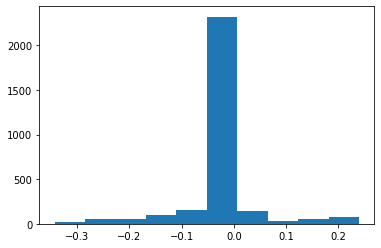

In [36]:
# (arg - np.array([ 0.22748329,  0.14347284, -0.31690967, -0.09126362, -0.3803397 ,
#         -0.16394056])) / np.array([0.26493645, 0.20685168, 0.11630305, 0.12485585, 0.1740476 ,
#         0.18915313])
plt.hist(arg.flatten())

In [87]:
np.array(means).mean(axis=0),  np.array(means).std(axis=0) # , np.array(mins).min(axis=0)

(array([-0.01527036, -0.01583448,  0.02519814,  0.02748504,  0.00434698,
        -0.0465755 ]),
 array([0.9685    , 0.98335612, 0.9577198 , 0.95297185, 0.97983495,
        0.99298225]))

In [146]:
np.array(mins).mean(axis=0), np.array(mins).std(axis=0) # , np.array(mins).min(axis=0)

/tmp/ipykernel_3055377/3515406556.py:1: RuntimeWarning: Mean of empty slice.
  np.array(mins).mean(axis=0), np.array(mins).std(axis=0) # , np.array(mins).min(axis=0)
/common/users/dm1487/envs/inhand_py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/common/users/dm1487/envs/inhand_py38/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/common/users/dm1487/envs/inhand_py38/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/common/users/dm1487/envs/inhand_py38/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(nan, nan)

In [184]:
np.array(maxs).mean(axis=0), np.array(maxs).std(axis=0) # , np.array(mins).min(axis=0)

/tmp/ipykernel_3055377/3689302195.py:1: RuntimeWarning: Mean of empty slice.
  np.array(maxs).mean(axis=0), np.array(maxs).std(axis=0) # , np.array(mins).min(axis=0)


(nan, nan)

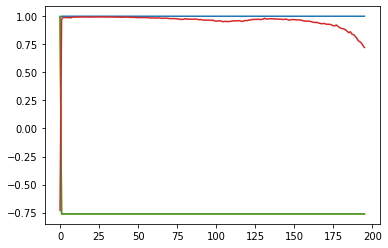

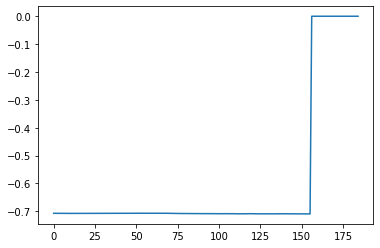

In [208]:
plt.plot(data['eef_pos'][:done_idx, 3])

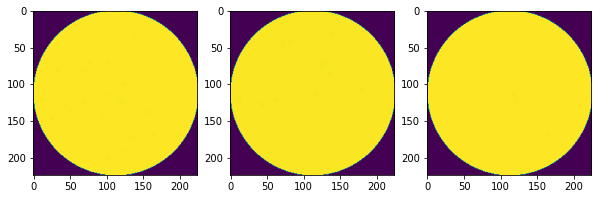

In [147]:
fig, ax = plt.subplots(1, 3, figsize=(10, 30))
t = 0

# (dat['tactile'][t][0]).min()


ax[0].imshow(dat['tactile'][t][0])
ax[1].imshow(dat['tactile'][t][1])
ax[2].imshow(dat['tactile'][t][2])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 292/292 [02:06<00:00,  2.31it/s]


In [239]:
def denormalize_image(image, min_value, max_value):
    denormalized_image = (image + 1) * 0.5 # * (max_value - min_value) + min_value
    return denormalized_image

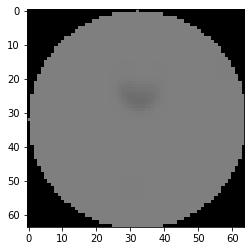

In [80]:
plt.imshow(denormalize_image(data['tactile_img'][0][150, 0], 0, 1))

In [1]:
import torch
import time

In [36]:
a = torch.randn(1250000, 1000)

In [43]:
st = time.time()
a = a.to('cuda:0')
time.time() - st

6.580352783203125e-05